# Лабораторная работа №2

In [ ]:
# Loading extension for reloading editable packages (pip install -e .)
%load_ext autoreload

In [ ]:
# Reloading editable packages.
%autoreload
# from lab1.main import get_results

Вариант для задания №3:
1. Номер группы + 15 = 2 + 15 = 17
2. Номер варианта + 56 = 14 + 56 = 70
3. ИУ5 (Номер варианта + 21) = 14 + 21 = 35

In [10]:
import pickle
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from numpy.typing import ArrayLike
from PIL import Image
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

%matplotlib inline

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Классификация изображений CIFAR100
### Загрузка и распаковка набора данных CIFAR100

In [2]:
import os
import shutil
import urllib
from pathlib import Path

url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
filename = "cifar-100-python.tar.gz"
model_path = Path("data")

model_path.mkdir(exist_ok=True)

file_path = model_path / filename

if not os.path.isfile(file_path):
    urllib.request.urlretrieve(url, file_path)
    shutil.unpack_archive(file_path, extract_dir=model_path)
    file_path.unlink()  # Remove archive after extracting it.

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

### Чтение тренировочной и тестовой выборки

In [3]:
def stem_extensions(filename: Path):
    extensions = "".join(filename.suffixes)

    return str(filename).removesuffix(extensions)

In [4]:
dataset_path = Path(stem_extensions(file_path))

with open(dataset_path / "train", "rb") as f:
    data_train = pickle.load(f, encoding="latin1")
with open(dataset_path / "test", "rb") as f:
    data_test = pickle.load(f, encoding="latin1")

# Классы по варианту.
CLASSES = [17, 70, 35]

train_X_raw = data_train["data"].reshape(-1, 3, 32, 32)
train_X_raw = np.transpose(train_X_raw, [0, 2, 3, 1])  # NCHW -> NHWC
train_y_raw = np.array(data_train["fine_labels"])
mask = np.isin(train_y_raw, CLASSES)
train_X = train_X_raw[mask].copy()
train_y = train_y_raw[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test["data"].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test["fine_labels"])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test

# print(train_y_raw.tolist())

In [5]:
def createImage(data: ArrayLike):
    return Image.fromarray(data).resize((256, 256))

In [6]:
# Source: https://stackoverflow.com/a/47334314
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns + 1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis("off")
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

class_id = 17:


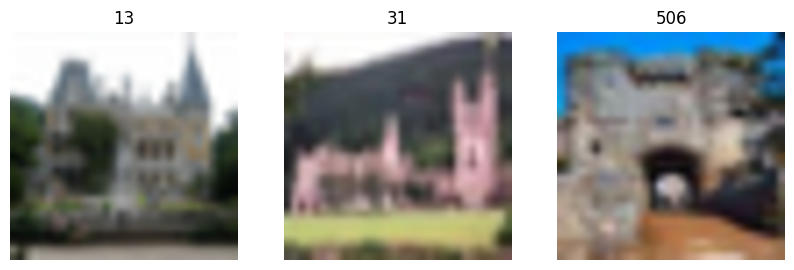

class_id = 70:


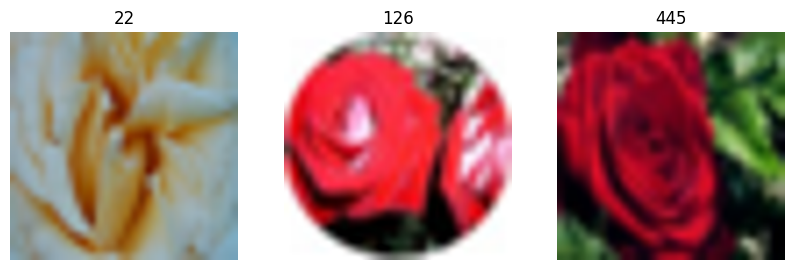

class_id = 35:


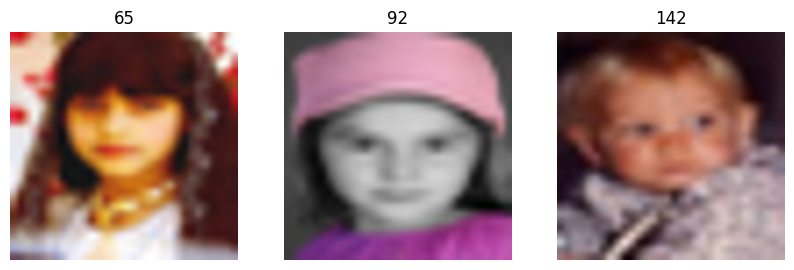

In [7]:
# По 3 экземпляра класса из выборки.
number_of_images_per_class_to_show = 3

for class_id in CLASSES:
    print(f"{class_id = }:")
    i = number_of_images_per_class_to_show
    image_index_for_class = -1
    class_images = []
    image_indices = []

    while i > 0:
        image_index_for_class = train_y_raw.tolist().index(
            class_id, image_index_for_class + 1
        )
        image_indices.append(image_index_for_class)
        class_images.append(createImage(train_X_raw[image_index_for_class]))
        i -= 1
    grid_display(class_images, image_indices, number_of_images_per_class_to_show)
    plt.show()

### Создание Pytorch DataLoader'a

In [11]:
def create_dataloader(batch_size=128):
    dataloader: dict[str, DataLoader] = {}
    for (X, y), part in zip([(train_X, train_y), (test_X, test_y)], ["train", "test"]):
        tensor_x = torch.Tensor(X)
        tensor_y = (
            F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=len(CLASSES)) / 1.0
        )
        dataset = TensorDataset(tensor_x, tensor_y)  # создание объекта датасета
        dataloader[part] = DataLoader(
            dataset, batch_size=batch_size, shuffle=True
        )  # создание экземпляра класса DataLoader

    return dataloader

### Создание Pytorch модели свёрточной нейронной сети

In [38]:
HIDDEN_SIZE = 32


class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2)  # nhwc -> nm


class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)


class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, classes=100):
        super(Cifar100_CNN, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.seq = nn.Sequential(
            Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
            # первый способ уменьшения размерности картинки - через stride
            nn.Conv2d(3, hidden_size, 5, stride=4, padding=2),
            nn.ReLU(),
            # второй способ уменьшения размерности картинки - через слой пуллинг
            nn.Conv2d(hidden_size, hidden_size * 2, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(4),  # nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(hidden_size * 8, classes),
        )

    def forward(self, input):
        return self.seq(input)


model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
# NEW
model.to(device)
print(model(torch.rand(1, 32, 32, 3).to(device)))
summary(model, input_size=(32, 32, 3))
weights = list(model.parameters())[0].detach().numpy()
weights.shape

tensor([[ 0.2085,  0.1401, -0.1024]], grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2             [-1, 32, 8, 8]           2,432
              ReLU-3             [-1, 32, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
              ReLU-5             [-1, 64, 8, 8]               0
         AvgPool2d-6             [-1, 64, 2, 2]               0
           Flatten-7                  [-1, 256]               0
            Linear-8                    [-1, 3]             771
Total params: 21,699
Trainable params: 21,699
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 0.08
Estimated Total Size (MB): 0.22
---------------------------------------------

(32, 3, 5, 5)

### Обучение модели по эпохам

In [27]:
REDRAW_EVERY = 20
EPOCHS = 250


def train(
    model: nn.Module,
    criterion: nn.CrossEntropyLoss,
    optimizer: optim.Optimizer,
    dataloader: dict[str, DataLoader],
    epochs=EPOCHS,
):
    steps_per_epoch = len(dataloader["train"])
    steps_per_epoch_val = len(dataloader["test"])

    # New
    pbar = tqdm(total=epochs * steps_per_epoch)
    losses = []
    losses_val = []
    passed = 0
    for epoch in range(epochs):  # проход по набору данных несколько раз
        tmp = []
        model.train()
        for i, batch in enumerate(dataloader["train"], 0):
            # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
            inputs, labels = batch

            # очищение прошлых градиентов с прошлой итерации
            optimizer.zero_grad()

            # прямой + обратный проходы + оптимизация
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            # для подсчёта статистик
            accuracy = (
                labels.detach().argmax(dim=-1) == outputs.detach().argmax(dim=-1)
            ).to(torch.float32).mean().cpu() * 100
            tmp.append((loss.item(), accuracy.item()))
            pbar.update(1)
        losses.append(
            (
                np.mean(tmp, axis=0),
                np.percentile(tmp, 25, axis=0),
                np.percentile(tmp, 75, axis=0),
            )
        )
        tmp = []
        model.eval()
        with torch.no_grad():  # отключение автоматического дифференцирования
            for i, data in enumerate(dataloader["test"], 0):
                inputs, labels = data
                # на GPU
                # inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                accuracy = (labels.argmax(dim=-1) == outputs.argmax(dim=-1)).to(
                    torch.float32
                ).mean().cpu() * 100
                tmp.append((loss.item(), accuracy.item()))
        losses_val.append(
            (
                np.mean(tmp, axis=0),
                np.percentile(tmp, 25, axis=0),
                np.percentile(tmp, 75, axis=0),
            )
        )
        if (epoch + 1) % REDRAW_EVERY != 0:
            continue
        clear_output(wait=False)
        passed += pbar.format_dict["elapsed"]
        pbar = tqdm(total=EPOCHS * steps_per_epoch, miniters=5)
        pbar.update((epoch + 1) * steps_per_epoch)
        x_vals = np.arange(epoch + 1)
        _, ax = plt.subplots(1, 2, figsize=(15, 5))
        stats = np.array(losses)
        stats_val = np.array(losses_val)
        ax[1].set_ylim(stats_val[:, 0, 1].min() - 5, 100)
        ax[1].grid(axis="y")
        for i, title in enumerate(["CCE", "Accuracy"]):
            ax[i].plot(x_vals, stats[:, 0, i], label="train")
            ax[i].fill_between(x_vals, stats[:, 1, i], stats[:, 2, i], alpha=0.4)
            ax[i].plot(x_vals, stats_val[:, 0, i], label="val")
            ax[i].fill_between(
                x_vals, stats_val[:, 1, i], stats_val[:, 2, i], alpha=0.4
            )
            ax[i].legend()
            ax[i].set_title(title)
        plt.show()

    print("Обучение закончено за %s секунд" % passed)
    return dataloader

### Выбор функции потерь и оптимизатора градиентного спуска

 96%|█████████▌| 2880/3000 [00:02<00:00, 1115.69it/s]


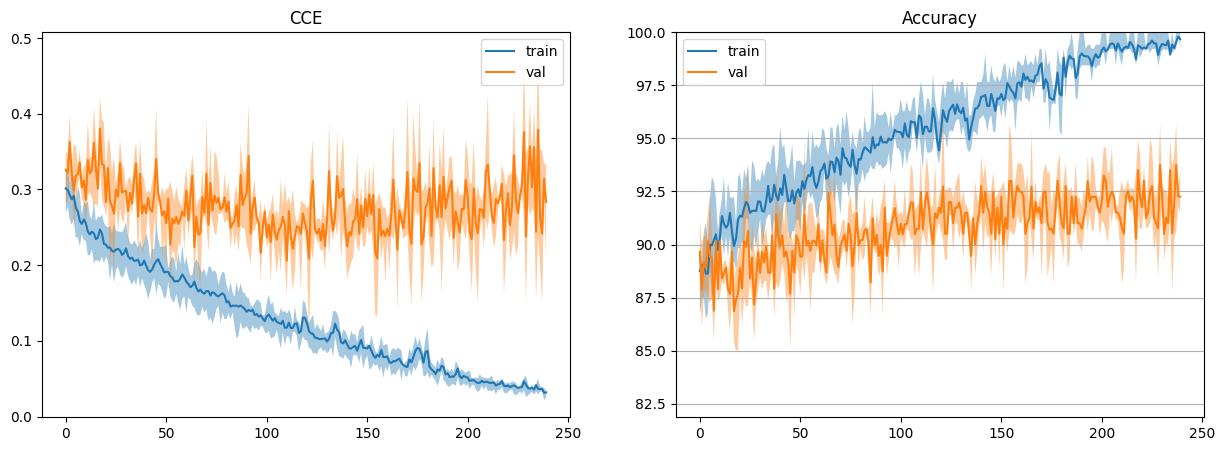

100%|██████████| 3000/3000 [00:01<00:00, 2092.38it/s]

Обучение закончено за 30.811923503875732 секунд


In [28]:
def train_classifier(
    model: nn.Module, learning_rate=5e-3, batch_size=128, epochs=EPOCHS, momentum=0.9
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    dataloader = create_dataloader(batch_size=batch_size)

    return train(
        model,
        criterion=criterion,
        optimizer=optimizer,
        dataloader=dataloader,
        epochs=epochs,
    )


dataloader = train_classifier(model)

### Проверка качества модели по классам на обучающей и тестовой выборках

In [39]:
def report_classification_results(dataloader: DataLoader):
    y_pred = []
    y_true = []
    with torch.no_grad():  # отключение автоматического дифференцирования
        for _, data in enumerate(dataloader, 0):
            inputs, labels = data
            # на GPU
            # inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(
            classification_report(
                y_true.argmax(axis=-1),
                y_pred.argmax(axis=-1),
                digits=4,
                target_names=list(map(str, CLASSES)),
            )
        )

In [40]:
def compare_classification_reports(dataloader: dict[str, DataLoader]):
    for part in ["train", "test"]:
        print(part)
        report_classification_results(dataloader[part])
        part != "test" and print("-" * 53)


compare_classification_reports(dataloader)

train
              precision    recall  f1-score   support

          17     0.3561    0.9480    0.5177       500
          70     0.4412    0.0900    0.1495       500
          35     0.0597    0.0080    0.0141       500

    accuracy                         0.3487      1500
   macro avg     0.2857    0.3487    0.2271      1500
weighted avg     0.2857    0.3487    0.2271      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.3392    0.9600    0.5013       100
          70     0.5455    0.0600    0.1081       100
          35     0.0000    0.0000    0.0000       100

    accuracy                         0.3400       300
   macro avg     0.2949    0.3400    0.2031       300
weighted avg     0.2949    0.3400    0.2031       300



### Анализ результатов обучения модели
Как видно, лучше всего был предсказан класс с идентификатором 17, представляющий
собой замки. Вероятнее всего это связано с количеством общих уникальных черт объектов
на картинках: у замков их намного меньше по сравнению с, например, ребёнком,
который может быть разного возраста, расы и может быть одет по-разному.

На лицо так же переобучение: в обучающей выборке характеристики были почти идеальными,
а в тестовых данных для некоторых классов средними. Скорректируем параметры для устранения
этого феномена в надежде улучшить качество модели.

Уменьшим количество эпох.


6000it [00:03, 1919.33it/s]:00<?, ?it/s]


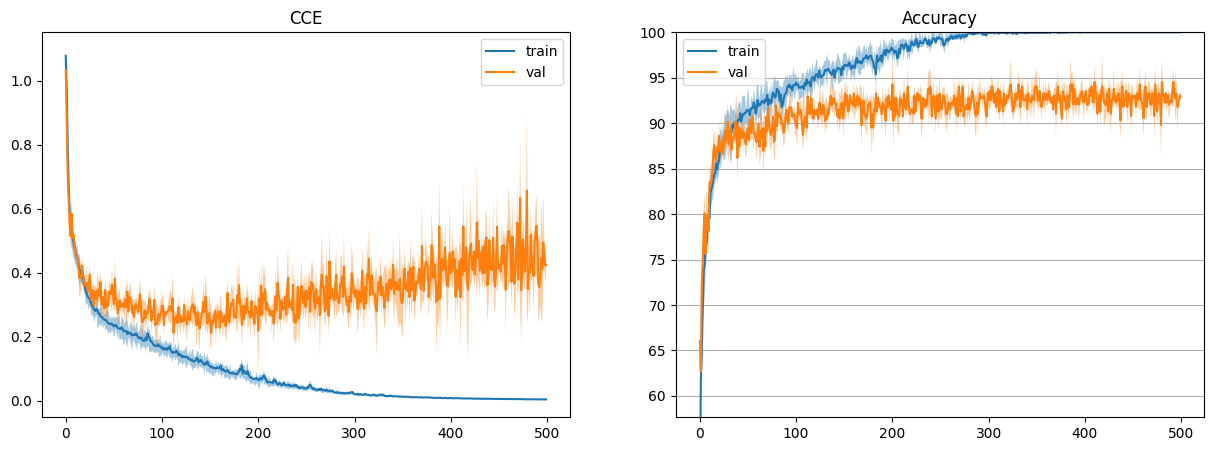

6000it [00:00, 14417.60it/s]            

Обучение закончено за 69.87626147270203 секунд
train
              precision    recall  f1-score   support

          17     1.0000    1.0000    1.0000       500
          70     1.0000    1.0000    1.0000       500
          35     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9789    0.9300    0.9538       100
          70     0.8716    0.9500    0.9091       100
          35     0.9479    0.9100    0.9286       100

    accuracy                         0.9300       300
   macro avg     0.9328    0.9300    0.9305       300
weighted avg     0.9328    0.9300    0.9305       300



In [41]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=500)
compare_classification_reports(dataloader)


 56%|█████▌    | 1680/3000 [00:02<00:02, 653.82it/s]


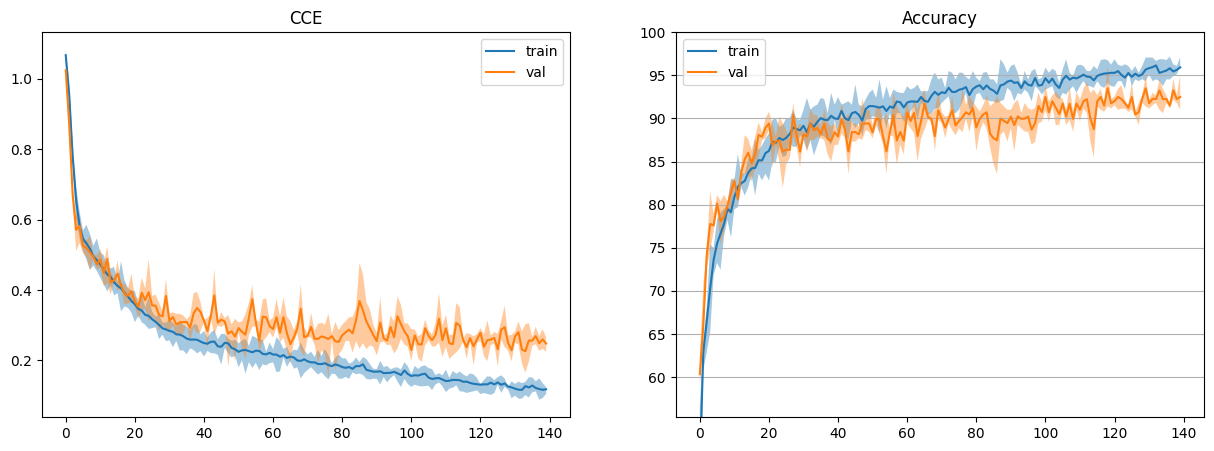


 60%|██████    | 1800/3000 [00:01<00:00, 1260.75it/s][A


Обучение закончено за 18.03901720046997 секунд
train
              precision    recall  f1-score   support

          17     0.9738    0.9660    0.9699       500
          70     0.9223    0.9740    0.9475       500
          35     0.9874    0.9400    0.9631       500

    accuracy                         0.9600      1500
   macro avg     0.9612    0.9600    0.9602      1500
weighted avg     0.9612    0.9600    0.9602      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9789    0.9300    0.9538       100
          70     0.8716    0.9500    0.9091       100
          35     0.9375    0.9000    0.9184       100

    accuracy                         0.9267       300
   macro avg     0.9293    0.9267    0.9271       300
weighted avg     0.9293    0.9267    0.9271       300



In [42]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=150)
compare_classification_reports(dataloader)

 64%|██████▍   | 1920/3000 [00:02<00:01, 693.22it/s]


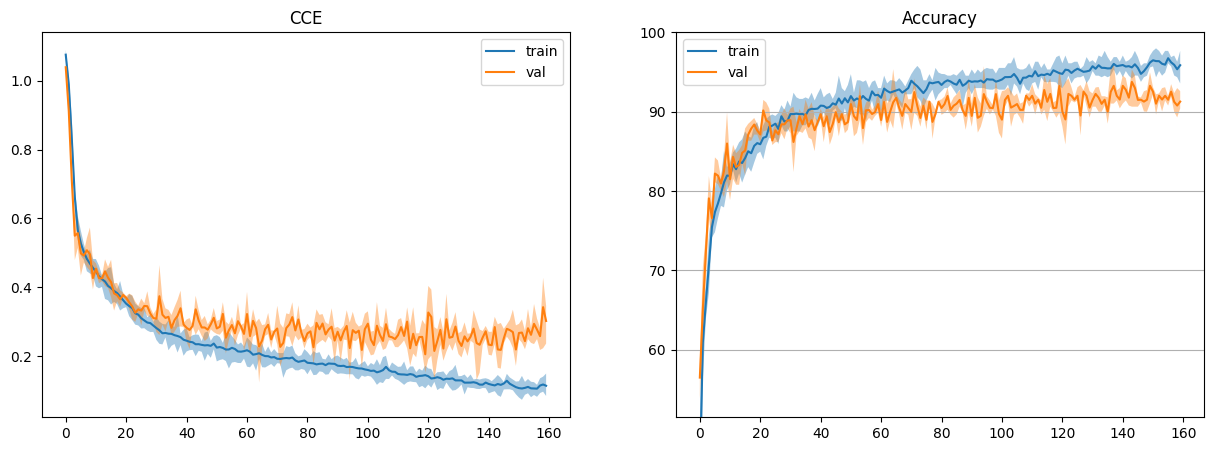

 64%|██████▍   | 1920/3000 [00:00<00:00, 5850.39it/s]

Обучение закончено за 22.280126571655273 секунд
train
              precision    recall  f1-score   support

          17     0.9681    0.9720    0.9701       500
          70     0.9615    0.9480    0.9547       500
          35     0.9703    0.9800    0.9751       500

    accuracy                         0.9667      1500
   macro avg     0.9666    0.9667    0.9666      1500
weighted avg     0.9666    0.9667    0.9666      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9592    0.9400    0.9495       100
          70     0.8911    0.9000    0.8955       100
          35     0.9109    0.9200    0.9154       100

    accuracy                         0.9200       300
   macro avg     0.9204    0.9200    0.9201       300
weighted avg     0.9204    0.9200    0.9201       300



In [43]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=160)
compare_classification_reports(dataloader)

Изменим конфигурацию модели.

 64%|██████▍   | 1920/3000 [00:03<00:02, 504.96it/s]


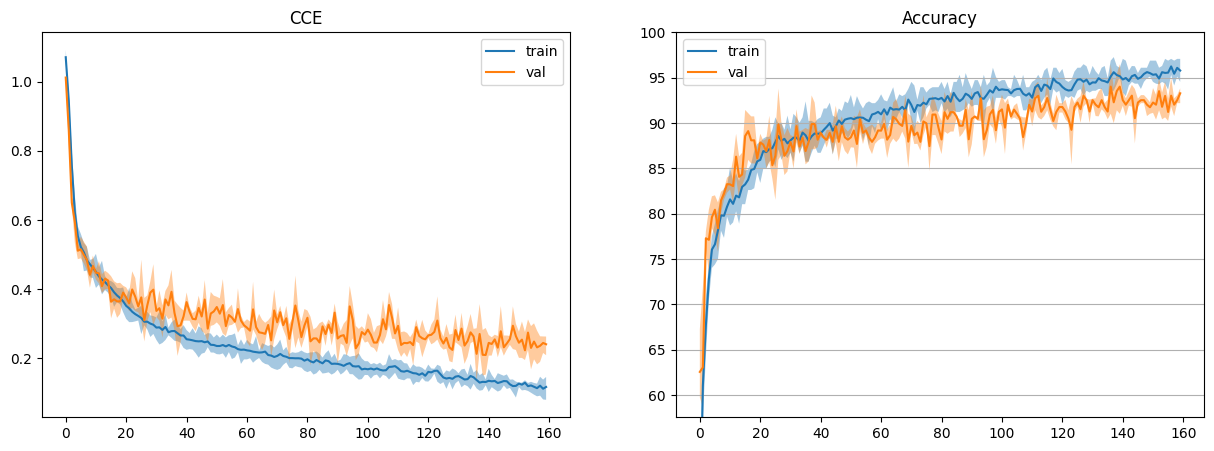

 64%|██████▍   | 1920/3000 [00:00<00:00, 3805.84it/s]

Обучение закончено за 30.07906675338745 секунд
train
              precision    recall  f1-score   support

          17     0.9718    0.9660    0.9689       500
          70     0.9219    0.9680    0.9444       500
          35     0.9874    0.9440    0.9652       500

    accuracy                         0.9593      1500
   macro avg     0.9604    0.9593    0.9595      1500
weighted avg     0.9604    0.9593    0.9595      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9688    0.9300    0.9490       100
          70     0.8704    0.9400    0.9038       100
          35     0.9479    0.9100    0.9286       100

    accuracy                         0.9267       300
   macro avg     0.9290    0.9267    0.9271       300
weighted avg     0.9290    0.9267    0.9271       300



In [57]:
class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, classes=100):
        super(Cifar100_CNN, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.seq = nn.Sequential(
            Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
            # первый способ уменьшения размерности картинки - через stride
            nn.Conv2d(3, hidden_size, 5, stride=2, padding=2),
            nn.ReLU(),
            # второй способ уменьшения размерности картинки - через слой пуллинг
            nn.Conv2d(hidden_size, hidden_size * 2, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(4),  # nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(hidden_size * 8, classes),
        )

    def forward(self, input):
        return self.seq(input)


model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
print(model)
dataloader = train_classifier(model, epochs=160)
compare_classification_reports(dataloader)


 32%|███▏      | 480/1500 [00:03<00:08, 127.37it/s]


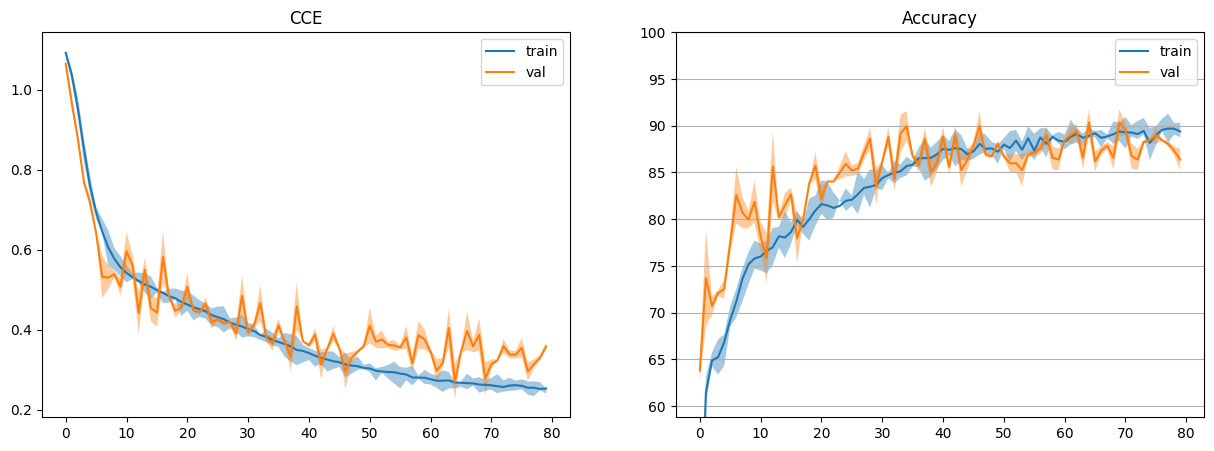

 32%|███▏      | 480/1500 [00:00<00:00, 1391.88it/s]

Обучение закончено за 14.75615906715393 секунд
train
              precision    recall  f1-score   support

          17     0.9294    0.9480    0.9386       500
          70     0.8922    0.8440    0.8674       500
          35     0.8859    0.9160    0.9007       500

    accuracy                         0.9027      1500
   macro avg     0.9025    0.9027    0.9022      1500
weighted avg     0.9025    0.9027    0.9022      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9474    0.9000    0.9231       100
          70     0.8454    0.8200    0.8325       100
          35     0.8519    0.9200    0.8846       100

    accuracy                         0.8800       300
   macro avg     0.8815    0.8800    0.8801       300
weighted avg     0.8815    0.8800    0.8801       300



In [59]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
print(model)
dataloader = train_classifier(model, batch_size=256, epochs=80)
compare_classification_reports(dataloader)


7680it [00:06, 1236.58it/s]:00<?, ?it/s]


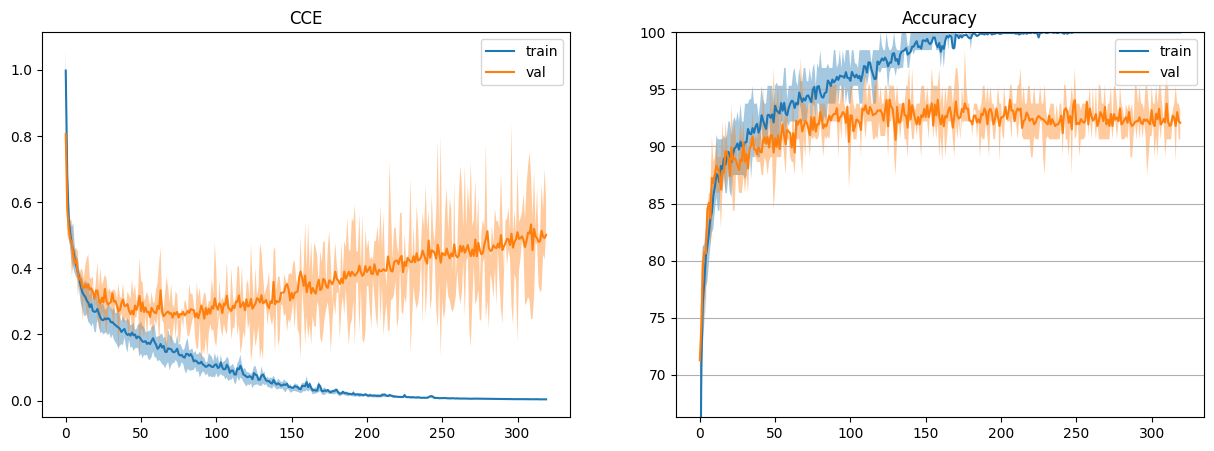

7680it [00:00, 17825.51it/s]            

Обучение закончено за 95.22503781318665 секунд
train
              precision    recall  f1-score   support

          17     1.0000    1.0000    1.0000       500
          70     1.0000    1.0000    1.0000       500
          35     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

-----------------------------------------------------
test


              precision    recall  f1-score   support

          17     0.9780    0.8900    0.9319       100
          70     0.8559    0.9500    0.9005       100
          35     0.9388    0.9200    0.9293       100

    accuracy                         0.9200       300
   macro avg     0.9242    0.9200    0.9206       300
weighted avg     0.9242    0.9200    0.9206       300



In [60]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
print(model)
dataloader = train_classifier(model, batch_size=64, epochs=320)
compare_classification_reports(dataloader)



 40%|████      | 2400/6000 [00:05<00:08, 415.58it/s]


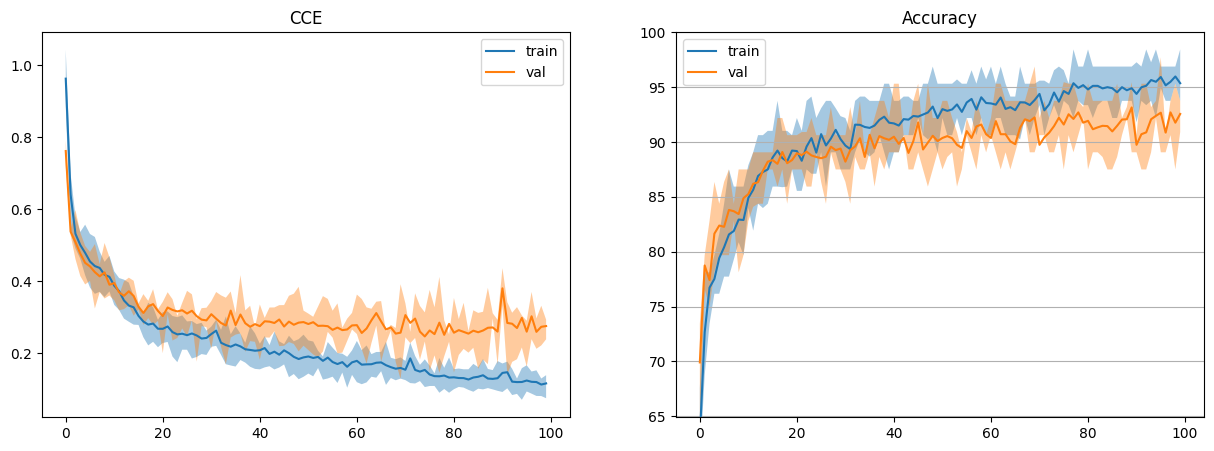



 40%|████      | 2401/6000 [00:00<00:00, 6621.85it/s]

 40%|████      | 2411/6000 [00:00<00:00, 4776.05it/s]

 40%|████      | 2425/6000 [00:00<00:01, 3177.67it/s]

 41%|████      | 2434/6000 [00:00<00:01, 2321.78it/s]

 41%|████      | 2445/6000 [00:00<00:02, 1657.54it/s]

 41%|████      | 2452/6000 [00:00<00:02, 1207.56it/s]

 41%|████      | 2460/6000 [00:01<00:04, 881.81it/s] 

 41%|████      | 2469/6000 [00:01<00:05, 642.85it/s]

 41%|████▏     | 2476/6000 [00:01<00:07, 476.33it/s]

 41%|████▏     | 2485/6000 [00:01<00:09, 356.83it/s]

 42%|████▏     | 2494/6000 [00:01<00:12, 273.99it/s]

 42%|████▏     | 2501/6000 [00:01<00:16, 212.94it/s]

 42%|████▏     | 2509/6000 [00:01<00:20, 172.39it/s]

 42%|████▏     | 2517/6000 [00:01<00:24, 144.79it/s]

 42%|████▏     | 2525/6000 [00:01<00:28, 122.65it/s]

 42%|████▏     | 2535/6000 [00:01<00:30, 115.44it/s]

 42%|████▏     | 2544/6000 [00:02<00:32, 106.91it/s]

 42%|████▎     | 2550/6000 [00:02<00:37, 92.29it/s] 

 43%|████▎     | 25

Обучение закончено за 28.915042400360107 секунд
train
              precision    recall  f1-score   support

          17     0.9666    0.9840    0.9752       500
          70     0.9696    0.9560    0.9627       500
          35     0.9839    0.9800    0.9820       500

    accuracy                         0.9733      1500
   macro avg     0.9734    0.9733    0.9733      1500
weighted avg     0.9734    0.9733    0.9733      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9596    0.9500    0.9548       100
          70     0.8738    0.9000    0.8867       100
          35     0.9286    0.9100    0.9192       100

    accuracy                         0.9200       300
   macro avg     0.9207    0.9200    0.9202       300
weighted avg     0.9207    0.9200    0.9202       300



In [65]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
print(model)
dataloader = train_classifier(model, batch_size=64, epochs=110)
compare_classification_reports(dataloader)

In [ ]:
class Cifar100_CNN_3(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, classes=100):
        super(Cifar100_CNN, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.seq = nn.Sequential(
            Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
            # первый способ уменьшения размерности картинки - через stride
            nn.Conv2d(3, hidden_size, 5, stride=2, padding=2),
            nn.ReLU(),
            # второй способ уменьшения размерности картинки - через слой пуллинг
            nn.Conv2d(hidden_size, hidden_size * 2, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_size * 2, hidden_size * 3, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(4),  # nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(hidden_size * 8, classes),
        )

    def forward(self, input):
        return self.seq(input)


model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
print(model)
dataloader = train_classifier(model, epochs=160)
compare_classification_reports(dataloader)

In [69]:
model_path = Path("models")
model_filename = "cifar_cnn.pt"

model_path.mkdir(exist_ok=True)

model_file_path = model_path / model_filename

torch.save(model, model_file_path)
# загрузка
new_model_2 = torch.load(model_file_path)
new_model_2.eval()

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [70]:
# входной тензор для модели
onnx_model_filename = "cifar100_cnn.onnx"
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(
    model,  # модель
    x,  # входной тензор (или кортеж нескольких тензоров)
    model_path/onnx_model_filename,  # куда сохранить (либо путь к файлу либо fileObject)
    export_params=True,  # сохраняет веса обученных параметров внутри файла модели
    opset_version=9,  # версия ONNX
    do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
    input_names=["input"],  # имя входного слоя
    output_names=["output"],  # имя выходного слоя
    dynamic_axes={
        "input": {
            0: "batch_size"
        },  # динамичные оси, в данном случае только размер пакета
        "output": {0: "batch_size"},
    },
)

In [ ]:
# входной тензор для модели
onnx_model_filename = "cifar100_fc.onnx"
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(
    model,  # модель
    x,  # входной тензор (или кортеж нескольких тензоров)
    model_path/onnx_model_filename,  # куда сохранить (либо путь к файлу либо fileObject)
    export_params=True,  # сохраняет веса обученных параметров внутри файла модели
    opset_version=9,  # версия ONNX
    do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
    input_names=["input"],  # имя входного слоя
    output_names=["output"],  # имя выходного слоя
    dynamic_axes={
        "input": {
            0: "batch_size"
        },  # динамичные оси, в данном случае только размер пакета
        "output": {0: "batch_size"},
    },
)